In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import os
import sys
import matplotlib.pyplot as plt
import json
import copy
import seaborn as sns

# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
EXTERNAL_LIBS_PATH = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
sys.path.insert(1, EXTERNAL_LIBS_PATH)

# Load cortum libs
import NN_interpretability as nn_inter
import Data_augmentation as data_aug

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Set parameters
params = {}
params['base_path'] = '/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability'
params['models_list'] = ['BL_t1', 'XC', 'RN', 'RN_t2', 'RN_t3', 'RN_t4']
params['prefix'] = 'Run_1'
params['CMA'] = 'CMA_0'
params['cells'] = ['340547', '307720', '321021', '232615', '205760', '379184']

plot_dir = os.path.join(params['base_path'], 'Plots')
os.makedirs(plot_dir, exist_ok=True)

# 1.- Load Data

## 1.1.- Load general data (independent to the model)

In [4]:
# Load metadata
with open(os.path.join(params['base_path'], 'Metadata', 'filtered_metadata.csv'), 'r') as file:
    metadata_df = pd.read_csv(file)
metadata_df.head()

mapobject_id_cell  mapobject_id plate_name well_name  well_pos_y  \
0             263042        263055    plate01       J16           0   
1             263043        263056    plate01       J16           0   
2             263044        263057    plate01       J16           0   
3             263045        263058    plate01       J16           0   
4             263047        263060    plate01       J16           0   

   well_pos_x  tpoint  zplane  label  is_border plate_name_cell  \
0           0       0       0      4          0         plate01   
1           0       0       0      5          0         plate01   
2           0       0       0      6          0         plate01   
3           0       0       0      7          0         plate01   
4           0       0       0      9          0         plate01   

  well_name_cell  well_pos_y_cell  well_pos_x_cell  tpoint_cell  zplane_cell  \
0            J16                0                0            0            0   
1            J16                0                0            0            0   
2            J16                0                0            0            0   
3            J16                0                0            0            0   
4            J16                0                0            0            0   

   label_cell  is_border_cell  is_mitotic  is_mitotic_labels  \
0           4               0         0.0                NaN   
1           5               0         0.0                NaN   
2           6               0         0.0                NaN   
3           7               0         0.0                NaN   
4           9               0         0.0                NaN   

   is_polynuclei_HeLa  is_polynuclei_HeLa_labels  is_polynuclei_184A1  \
0                 0.0                        NaN                  0.0   
1                 0.0                        NaN                  0.0   
2                 0.0                        NaN                  0.0   
3                 0.0                        NaN                  0.0   
4                 0.0                        NaN                  0.0   

   is_polynuclei_184A1_labels cell_cycle cell_type perturbation  duration  \
0                         NaN          S     184A1         DMSO     720.0   
1                         NaN          S     184A1         DMSO     720.0   
2                         NaN         G1     184A1         DMSO     720.0   
3                         NaN          S     184A1         DMSO     720.0   
4                         NaN         G1     184A1         DMSO     720.0   

   cell_size  00_DAPI_avg  07_H2B_avg  01_CDK9_pT186_avg  03_CDK9_avg  \
0     8401.0    39.610201  282.212391          14.709787    34.481345   
1    12207.0    34.884746  249.743762          14.587963    33.729957   
2    15734.0    31.429217  184.722779           7.892179    19.263491   
3    15767.0    43.349090  241.460906          18.110119    44.601291   
4    11930.0    28.164459  149.241408          27.710272    72.874109   

   05_GTF2B_avg  07_SETD1A_avg  08_H3K4me3_avg  09_SRRM2_avg  10_H3K27ac_avg  \
0    122.127518      29.408288       48.079878     56.508154       71.844750   
1    104.787060      25.446742       35.599046     54.977671       48.061287   
2     81.864454      23.929299       29.536900     39.606383       39.047856   
3    122.976267      40.604674       48.760110     58.076779       77.012867   
4    148.002903      51.391368       56.976488    116.255474       56.907744   

   11_KPNA2_MAX_avg  12_RB1_pS807_S811_avg  13_PABPN1_avg  14_PCNA_avg  \
0         93.999276             108.771761     157.808500    85.331438   
1         90.354757              97.722536     145.751775    95.141995   
2         77.348039              12.910413     149.859577    42.855445   
3        121.283321             104.755645     159.792550    84.807594   
4         66.943473              97.452245     187.995952    53.530015   

   15_SON_avg   16_H3_avg  17_HDAC3_avg 

In [5]:
# Load parameters
with open(os.path.join(params['base_path'], 'Metadata', 'parameters.json'), 'r') as file:
    model_params = json.load(file)
#model_params.keys()

In [6]:
# Load Channels
with open(os.path.join(params['base_path'], 'Metadata', 'channels.csv'), 'r') as file:
    channels_df = pd.read_csv(file)
# Get input channel ids
mask = channels_df.name.isin(model_params['input_channels'])
input_ids = channels_df[mask].channel_id.values
# Get output channel id
mask = channels_df.name == '00_EU'
output_id = channels_df[mask].channel_id.values[0]
# Get normalization values
norm_vals = channels_df.sort_values(by=['channel_id']).normalization_vals.values
channels_df

channel_id               name  normalization_vals    type
0            0            00_DAPI                74.0   input
1            1             07_H2B               333.0   input
2            2      01_CDK9_pT186                53.0   input
3            3            03_CDK9               104.0   input
4            4           05_GTF2B               203.0   input
5            5          07_SETD1A               108.0   input
6            6         08_H3K4me3               118.0   input
7            7           09_SRRM2               323.0   input
8            8         10_H3K27ac               193.0   input
9            9       11_KPNA2_MAX               130.0   input
10          10  12_RB1_pS807_S811               198.0   input
11          11          13_PABPN1               434.0   input
12          12            14_PCNA               166.0   input
13          13             15_SON               287.0   input
14          14              16_H3               480.0   input
15          15           17_HDAC3               169.0   input
16          16       19_KPNA1_MAX               158.0   input
17          17           20_SP100               397.0   input
18          18             21_NCL               223.0   input
19          19          01_PABPC1                58.0   input
20          20            02_CDK7               309.0   input
21          21            03_RPS6                49.0   input
22          22              05_Sm               117.0   input
23          23          07_POLR2A               364.0   input
24          24           09_CCNT1               225.0   input
25          25      10_POL2RA_pS2               581.0   input
26          26             11_PML               149.0   input
27          27            12_YAP1               213.0   input
28          28      13_POL2RA_pS5               481.0   input
29          29        15_U2SNRNPB                97.0   input
30          30            18_NONO               637.0   input
31          31          20_ALYREF               721.0   input
32          32            21_COIL                28.0   input
33          33           00_BG488                19.0   input
34          34           00_BG568                 9.0   input
35          36   09_SRRM2_ILASTIK             60065.0   input
36          37     15_SON_ILASTIK             60926.0   input
37          35              00_EU                 1.0  output

## 1.2.- Load Model Data

In [7]:
#models_path = os.path.join(params['base_path'], 'Models', params['model_dir'])
targets_df = pd.DataFrame()
for i, model in enumerate(params['models_list']):
    print('Reading predicted values for model: ', model)
    model_path = os.path.join(os.path.join(params['base_path'], 'Models', model, params['prefix']))
    temp_path = os.path.join(model_path, 'targets_'+params['CMA']+'.csv')
    with open(temp_path, 'r') as file:
        temp_df = pd.read_csv(file)
    temp_df = temp_df.drop(['y - y_hat'], axis=1)
    prediction_name = 'y_hat'+'_'+model
    temp_df[prediction_name] = temp_df.y_hat
    temp_df = temp_df.drop(['y_hat'], axis=1)
    if i == 0:
        targets_df = temp_df.copy()
    else:
        temp_df = temp_df[['mapobject_id_cell', prediction_name]]
        targets_df = targets_df.merge(temp_df, 
                                      left_on='mapobject_id_cell',
                                      right_on='mapobject_id_cell',
                                      how='left')
mask = targets_df.mapobject_id_cell.isin(np.array(params['cells'], dtype=np.int64))
round(targets_df[mask], 2)

Reading predicted values for model:  BL_t1
Reading predicted values for model:  XC
Reading predicted values for model:  RN
Reading predicted values for model:  RN_t2
Reading predicted values for model:  RN_t3
Reading predicted values for model:  RN_t4


y  mapobject_id_cell    set perturbation cell_cycle  y_hat_BL_t1  \
56    332.62             321021  train       normal         G1       335.83   
2376  440.33             340547  train         DMSO         G1       419.14   
2817  361.85             205760  train       normal         G1       429.29   
3006  319.87             232615    val       normal         G1       360.33   
3036  432.03             379184    val         DMSO          S       397.35   
3133  366.16             307720    val         DMSO         G1       318.26   

      y_hat_XC  y_hat_RN  y_hat_RN_t2  y_hat_RN_t3  y_hat_RN_t4  
56      348.68    354.70       352.96       351.89       351.89  
2376    387.15    449.03       395.87       407.67       407.67  
2817    358.72    440.74       407.95       392.40       392.40  
3006    353.26    353.23       343.45       344.63       344.63  
3036    380.86    395.30       387.57       382.68       382.68  
3133    312.07    342.67       323.62       323.56       323.56

## 1.3.- Load cells

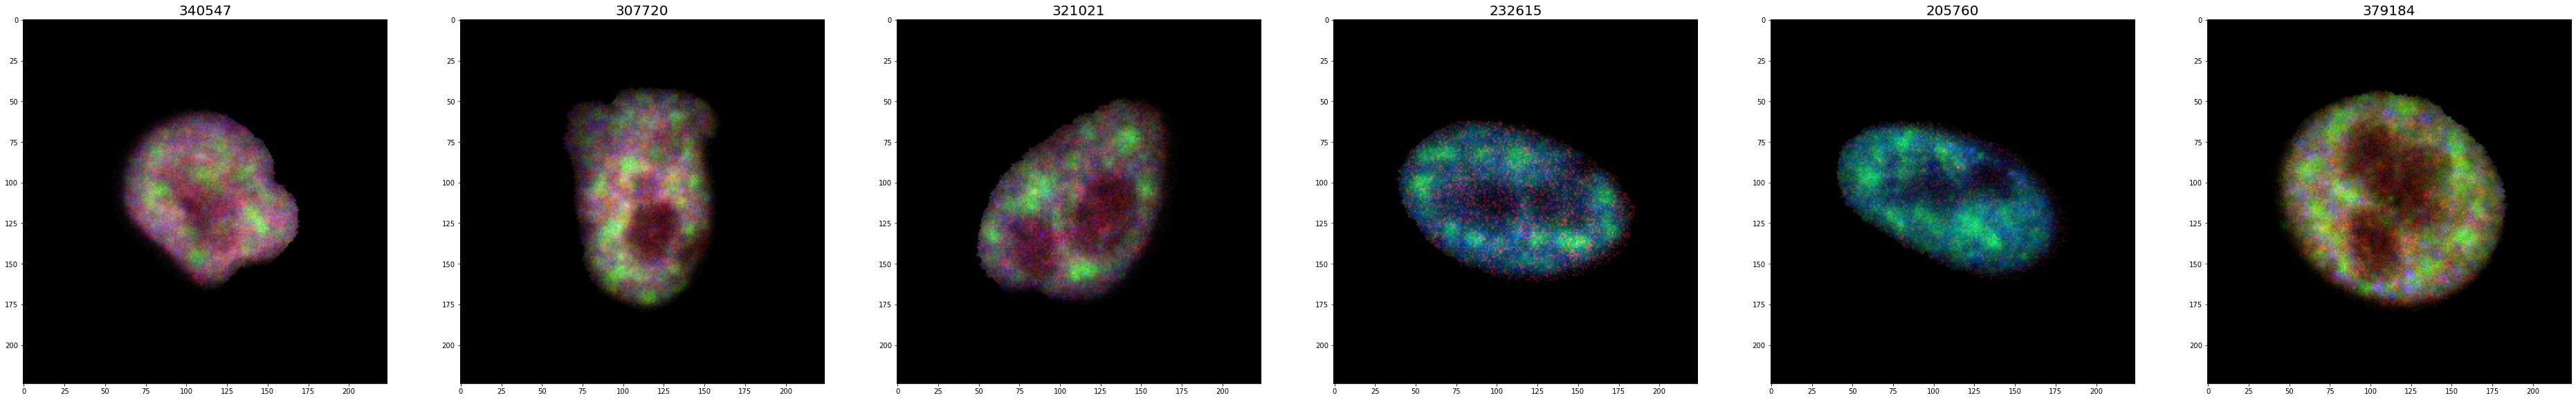

In [8]:
cells = {}
n_cells = len(params['cells'])
plt.figure(figsize=(n_cells*11,10))

for i, cell in enumerate(params['cells'], 1):
    temp_path = os.path.join(params['base_path'], 'Cells', cell+'.npz')
    temp_cell = np.load(temp_path)
    # Normalize cell
    cells[cell+'_img'] = copy.deepcopy(temp_cell['img'] / norm_vals)
    # filter accordingly to the input channels
    cells[cell+'_img'] = cells[cell+'_img'][:,:,input_ids].astype(np.float32)
    cells[cell+'_mask'] = copy.deepcopy(temp_cell['mask'])
    
    # Plot cells
    temp_img = (cells[cell+'_img'] / np.max(cells[cell+'_img'], axis=(0,1)))[:,:,10:13]
    plt.subplot(1, n_cells, i)
    nn_inter.plot_cell(img=temp_img, title=cell)

# 2.- Get Score Matrix for each cell (VarGrad IG)

# 2.2.- Load VarGrad IG

### Load Score Maps

In [10]:
VarGrad_IG = {}
for model in params['models_list']:
    print('Loading score maps from model ', model)
    temp_path_1 = os.path.join(params['base_path'], 'Score_maps', model)
    files = os.listdir(temp_path_1)
    # only load cells that match the prefix
    files = [f for f in files if f[0:len(params['prefix'])] == params['prefix']]
    # only load cells that match the selected ids
    files = [f for f in files if f[len(params['prefix'])+1:-4] in params['cells']]
    for f in files:
        print('\tLoading cell map ', f)
        temp_path_2 = os.path.join(temp_path_1, f)
        key = model+'_'+f[len(params['prefix'])+1:-4]
        VarGrad_IG[key] = np.load(temp_path_2)
    print("")

Loading score maps from model  BL_t1
	Loading cell map  Run_1_340547.npy
	Loading cell map  Run_1_205760.npy
	Loading cell map  Run_1_232615.npy
	Loading cell map  Run_1_307720.npy
	Loading cell map  Run_1_321021.npy
	Loading cell map  Run_1_379184.npy

Loading score maps from model  XC
	Loading cell map  Run_1_340547.npy
	Loading cell map  Run_1_205760.npy
	Loading cell map  Run_1_232615.npy
	Loading cell map  Run_1_307720.npy
	Loading cell map  Run_1_321021.npy
	Loading cell map  Run_1_379184.npy

Loading score maps from model  RN
	Loading cell map  Run_1_340547.npy
	Loading cell map  Run_1_205760.npy
	Loading cell map  Run_1_232615.npy
	Loading cell map  Run_1_307720.npy
	Loading cell map  Run_1_321021.npy
	Loading cell map  Run_1_379184.npy

Loading score maps from model  RN_t2
	Loading cell map  Run_1_340547.npy
	Loading cell map  Run_1_205760.npy
	Loading cell map  Run_1_232615.npy
	Loading cell map  Run_1_307720.npy
	Loading cell map  Run_1_321021.npy
	Loading cell map  Run_1_37

### Plote Score maps for both models and compare

In [11]:
params['cells']

['340547', '307720', '321021', '232615', '205760', '379184']

Plotting cell: 205760


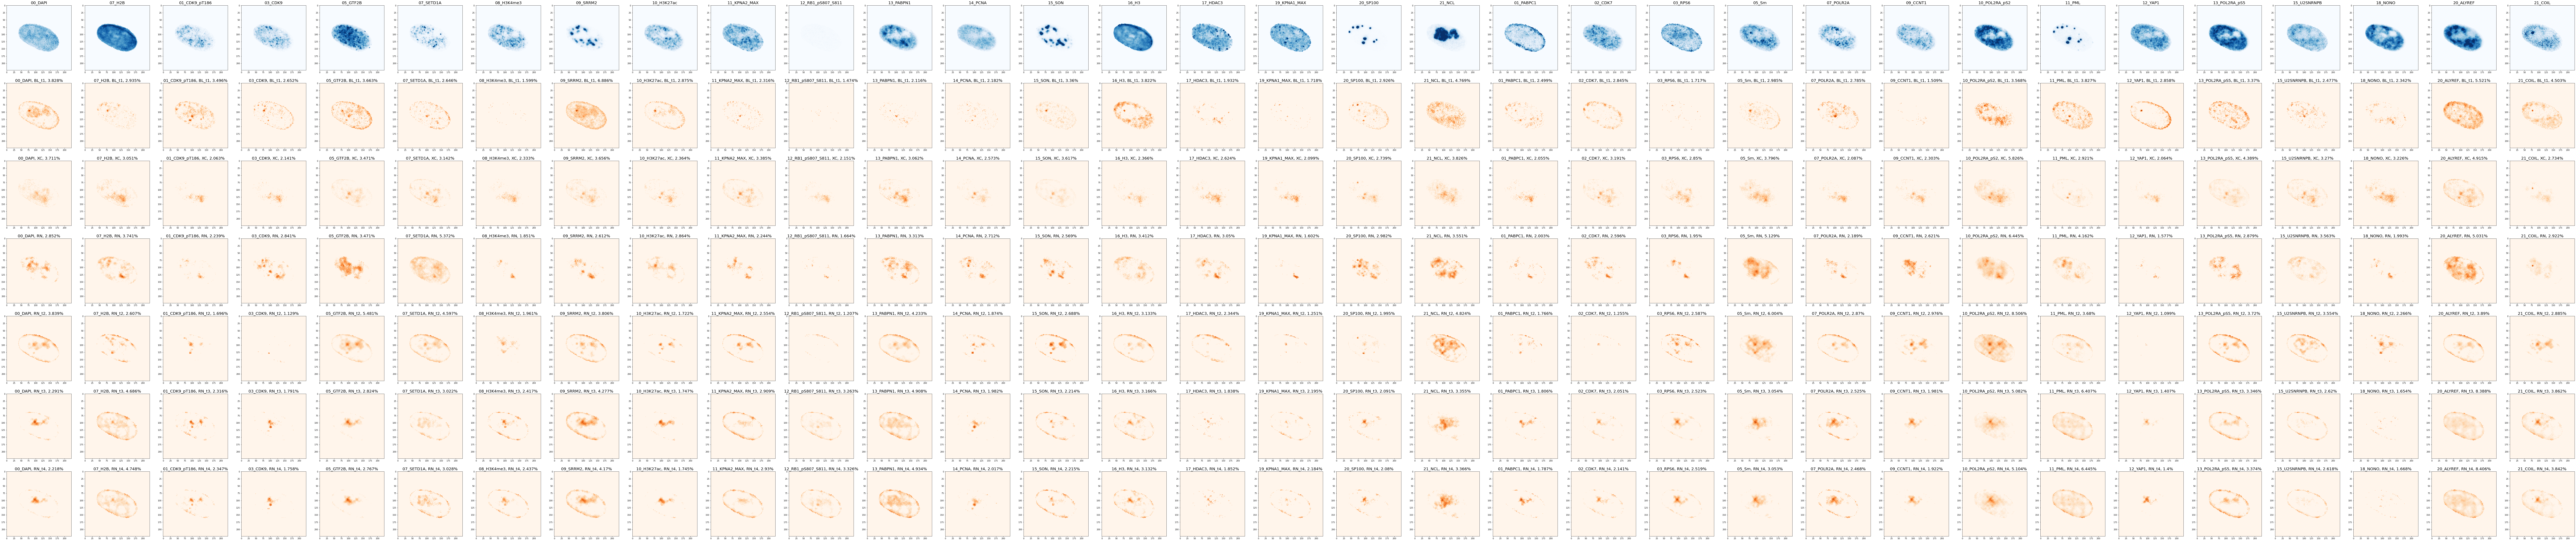

In [12]:
#for cell in params['cells']:
for cell in ['205760']:
    top_percent = 0.20
    plot_name = os.path.join(plot_dir, cell+'_'+str(top_percent)+'.jpg')
    print('Plotting cell: '+cell)
    temp_Score_maps = {key[:-7]: VarGrad_IG[key] for key in VarGrad_IG.keys() if cell in key}
    nn_inter.plot_VarGrad_IG_2(img=cells[cell+'_img'],
                               img_mask=cells[cell+'_mask'],
                               score_maps=temp_Score_maps,
                               top_percent=top_percent,
                               channels_df=channels_df,
                               img_size=(7,7),
                               score_map_same_sacale=False,
                               channels_2_plot=None,
                               plot_overlap=False,
                               plot_colorbar=False,
                               #plot_name=plot_name
                              )

# 3.- Comulative variance plot

In [13]:
mask = channels_df.channel_id.isin(input_ids)
channel_names = channels_df[mask].sort_values(by=['channel_id']).name.values

channel_stddev_df = pd.DataFrame()
for i, key in enumerate(VarGrad_IG.keys()):
    
    score_channel_std = []
    temp_score_map = VarGrad_IG[key]
    for c in range(temp_score_map.shape[-1]):
        score_channel_std.append(np.sum(temp_score_map[:,:,c]))
    total_stddev = np.sum(score_channel_std, axis=0)
        
    # Normalize the comulative stddev per channel
    for c in range(temp_score_map.shape[-1]):
        score_channel_std[c] /= total_stddev
    
    
    temp_df = pd.DataFrame(channel_names, columns=['channel_name'])
    temp_df['channel_var'] = score_channel_std
    temp_df['mapobject_id_cell'] = key[-6:]
    temp_df['Model'] = key[0:-7]
    
    channel_stddev_df = channel_stddev_df.append(temp_df, ignore_index=True)
channel_stddev_df

channel_name  channel_var mapobject_id_cell  Model
0           00_DAPI     0.039259            340547  BL_t1
1            07_H2B     0.029822            340547  BL_t1
2     01_CDK9_pT186     0.026906            340547  BL_t1
3           03_CDK9     0.028610            340547  BL_t1
4          05_GTF2B     0.035952            340547  BL_t1
...             ...          ...               ...    ...
1183  13_POL2RA_pS5     0.035105            379184  RN_t4
1184    15_U2SNRNPB     0.025348            379184  RN_t4
1185        18_NONO     0.017664            379184  RN_t4
1186      20_ALYREF     0.081097            379184  RN_t4
1187        21_COIL     0.036227            379184  RN_t4

[1188 rows x 4 columns]

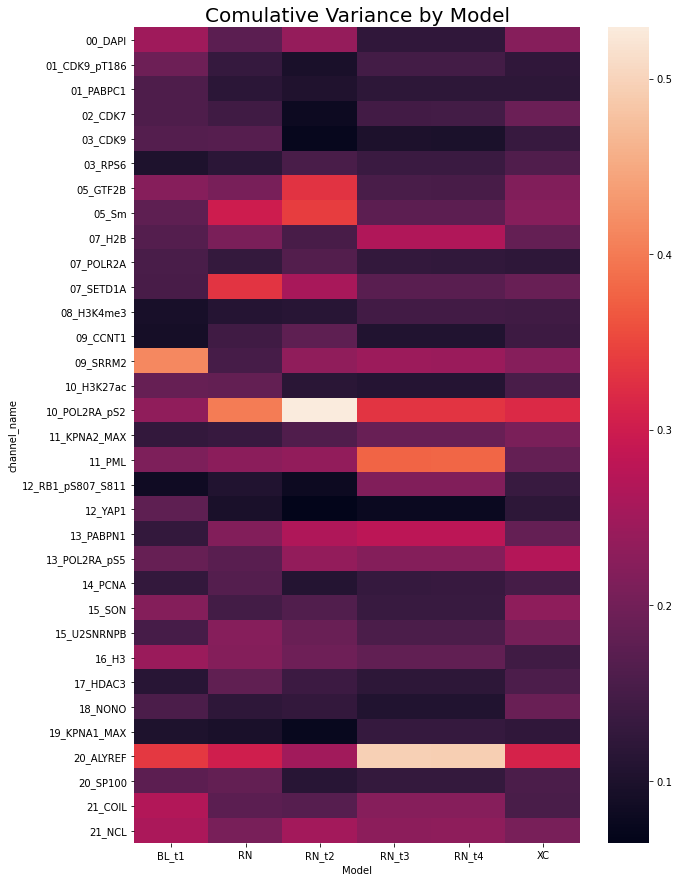

In [14]:
temp_df = channel_stddev_df.copy()
temp_df = temp_df.groupby(['channel_name', 'Model']).sum().reset_index()
temp_df = temp_df.pivot('channel_name', 'Model', 'channel_var')
#temp_df = temp_df.sort_index(level=0, ascending=True)

plt.figure(figsize=(10,15))
sns.heatmap(temp_df)
_ = plt.title('Comulative Variance by Model', fontsize=20)

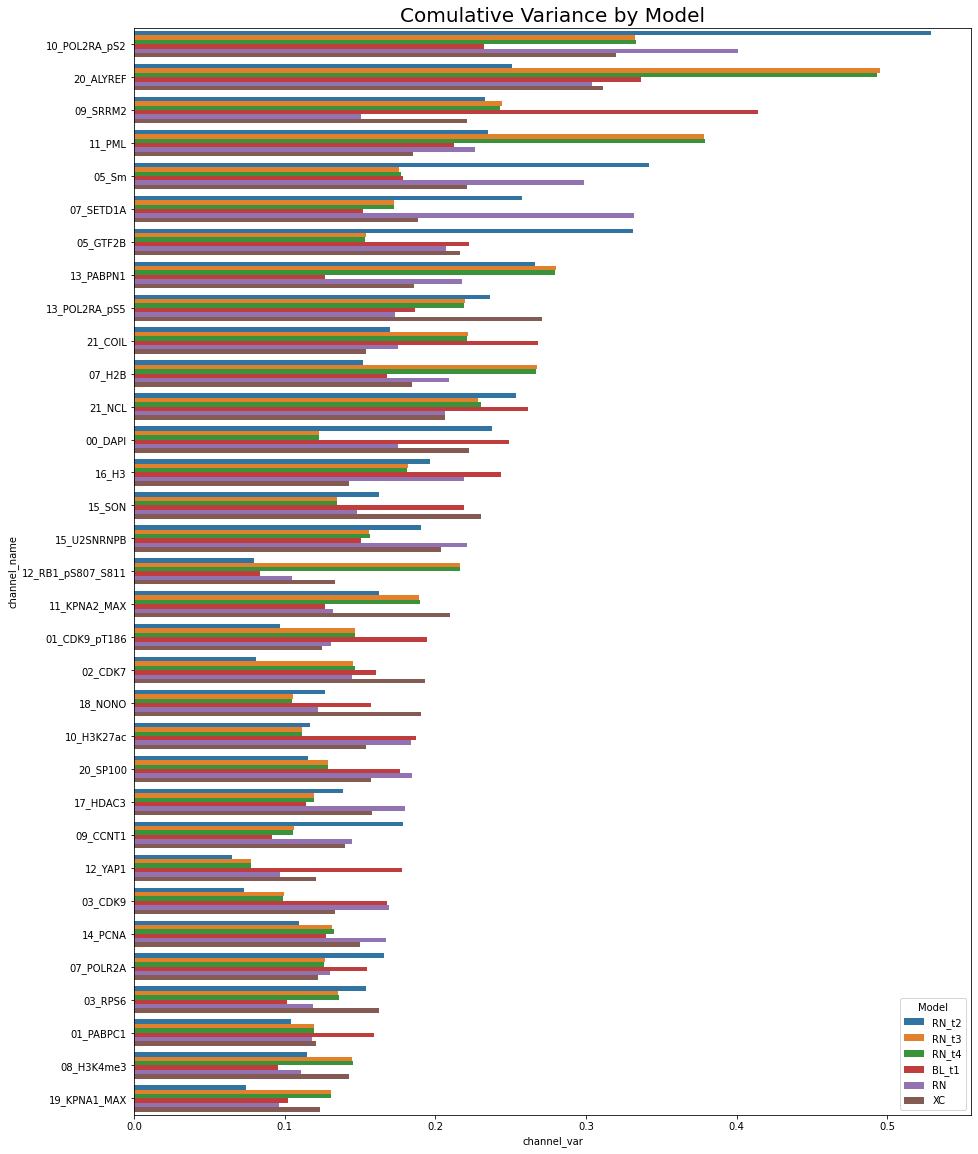

In [15]:
temp_df = channel_stddev_df.copy()
temp_df = temp_df.groupby(['channel_name', 'Model']).sum().reset_index()
temp_df = temp_df.sort_values(by=['channel_var', 'Model'], ascending=False)
    
plt.figure(figsize=(15,20))
sns.barplot(
        data=temp_df,
        x="channel_var",
        y="channel_name",
        hue="Model",
        #hue_order=order,
        orient="h",
        #palette="viridis"
        )
_ = plt.title('Comulative Variance by Model', fontsize=20)

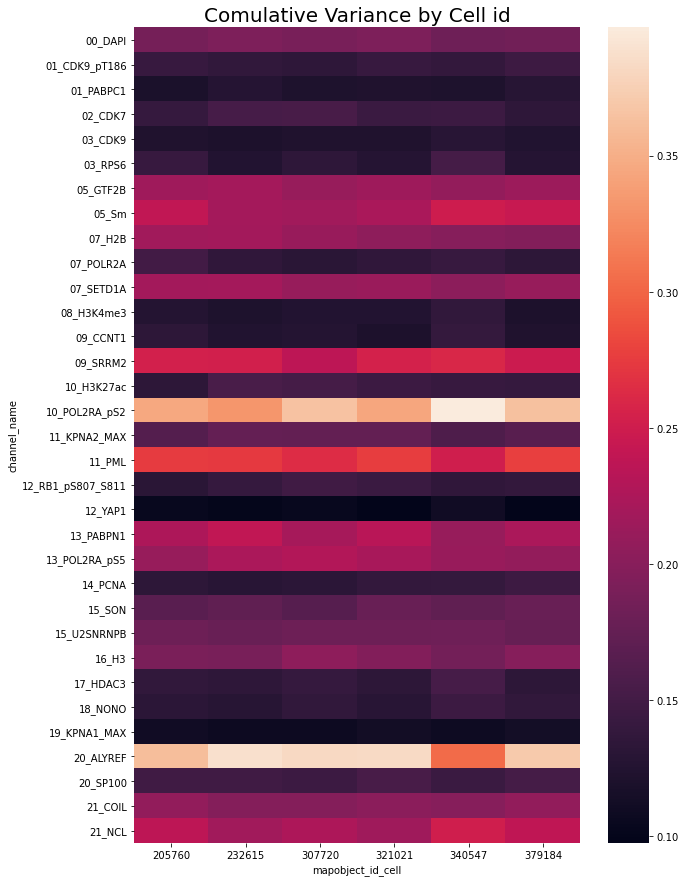

In [16]:
temp_df = channel_stddev_df.copy()
temp_df = temp_df.groupby(['channel_name', 'mapobject_id_cell']).sum().reset_index()
temp_df = temp_df.pivot('channel_name', 'mapobject_id_cell', 'channel_var')
temp_df = temp_df.sort_index(level=0, ascending=True)


plt.figure(figsize=(10,15))
sns.heatmap(temp_df)
_ = plt.title('Comulative Variance by Cell id', fontsize=20)

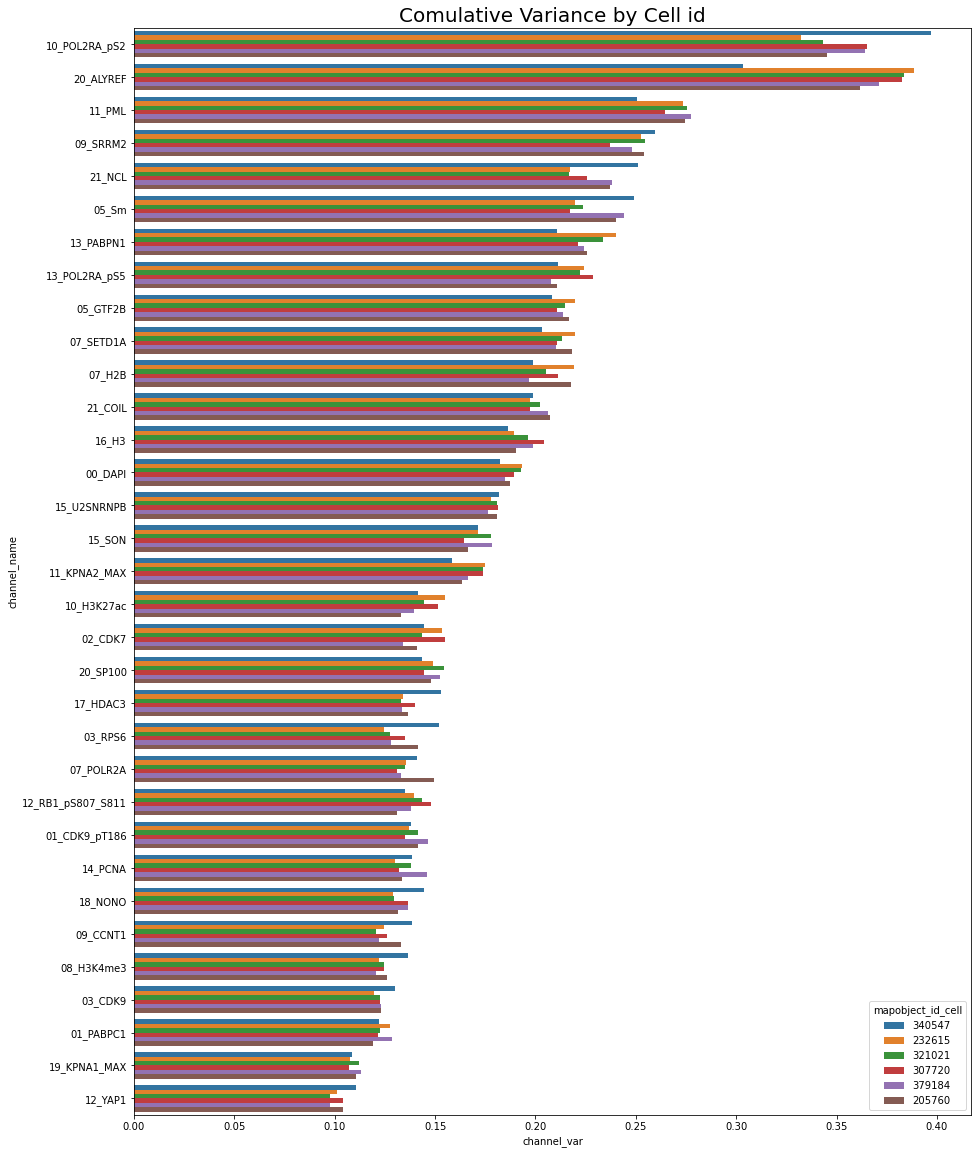

In [17]:
temp_df = channel_stddev_df.copy()
temp_df = temp_df.groupby(['channel_name', 'mapobject_id_cell']).sum().reset_index()
temp_df = temp_df.sort_values(by=['channel_var', 'mapobject_id_cell'], ascending=False)
    
plt.figure(figsize=(15,20))
sns.barplot(
        data=temp_df,
        x="channel_var",
        y="channel_name",
        hue="mapobject_id_cell",
        #hue_order=order,
        orient="h",
        #palette="viridis"
        )
_ = plt.title('Comulative Variance by Cell id', fontsize=20)

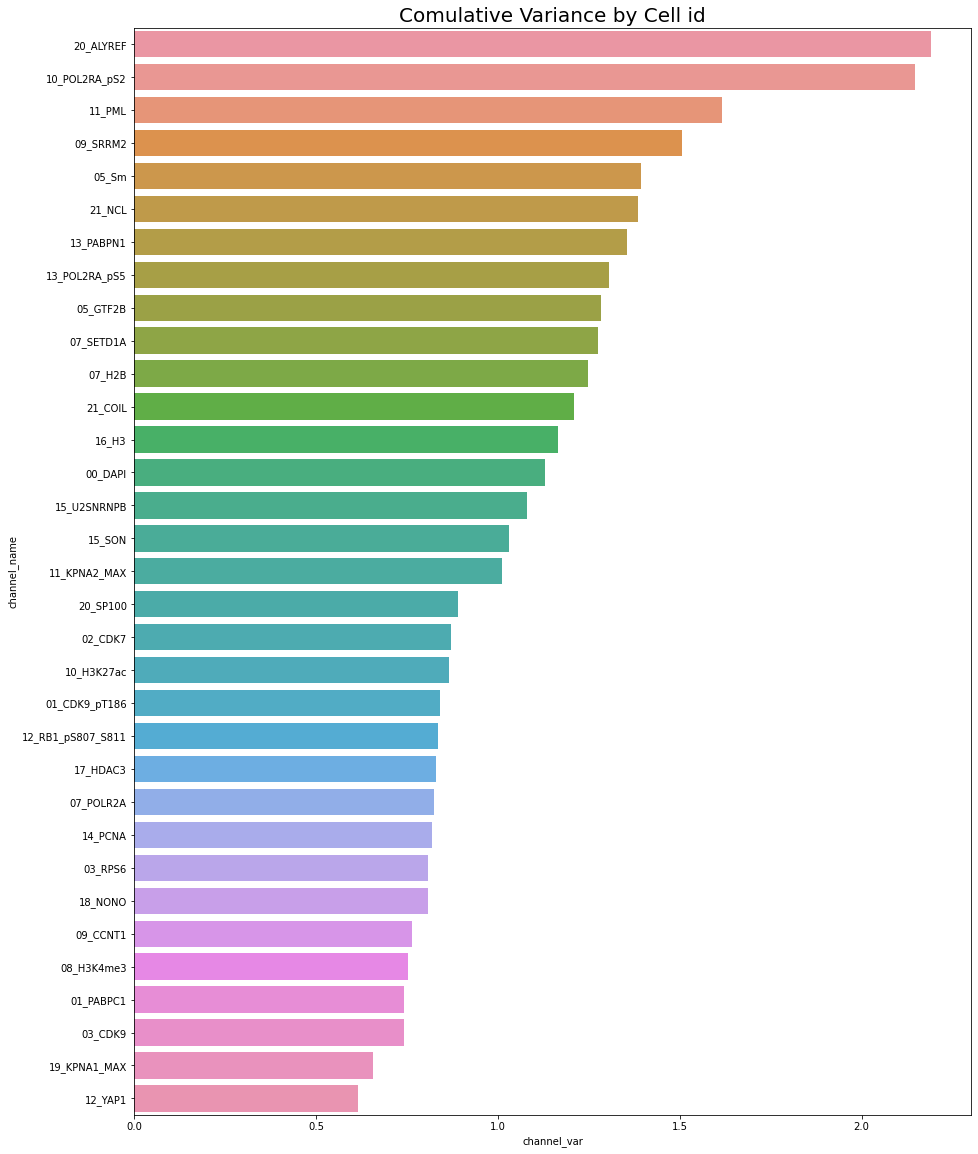

In [18]:
temp_df = channel_stddev_df.copy()
temp_df = temp_df.groupby(['channel_name']).sum().reset_index()
temp_df = temp_df.sort_values(by=['channel_var'], ascending=False)
    
plt.figure(figsize=(15,20))
sns.barplot(
        data=temp_df,
        x="channel_var",
        y="channel_name",
        #hue_order=order,
        orient="h",
        #palette="viridis"
        )
_ = plt.title('Comulative Variance by Cell id', fontsize=20)

In [19]:
params['models_list']

['BL_t1', 'XC', 'RN', 'RN_t2', 'RN_t3', 'RN_t4']

In [20]:
mask = (channel_stddev_df.Model == 'BL_t1')
temp_df = channel_stddev_df[mask].copy()
temp_df = temp_df.groupby(['channel_name']).sum().reset_index()
temp_df = temp_df.sort_values(by=['channel_var'], ascending=False).reset_index()
temp_df = temp_df.drop(['index'], axis=1)
total = np.sum(temp_df.channel_var)
temp_df.channel_var = (temp_df.channel_var / total)
temp_df['Cum_var'] = temp_df.channel_var.cumsum()

temp_df[temp_df.Cum_var < 0.8].tail(1)

channel_name  channel_var   Cum_var
21    07_POLR2A     0.025762  0.787882

In [21]:
mask = (channel_stddev_df.Model == 'XC')
temp_df = channel_stddev_df[mask].copy()
temp_df = temp_df.groupby(['channel_name']).sum().reset_index()
temp_df = temp_df.sort_values(by=['channel_var'], ascending=False).reset_index()
temp_df = temp_df.drop(['index'], axis=1)
total = np.sum(temp_df.channel_var)
temp_df.channel_var = (temp_df.channel_var / total)
temp_df['Cum_var'] = temp_df.channel_var.cumsum()

temp_df[temp_df.Cum_var < 0.8].tail(1)

channel_name  channel_var   Cum_var
22      14_PCNA     0.024971  0.782703

In [22]:
mask = (channel_stddev_df.Model == 'RN')
temp_df = channel_stddev_df[mask].copy()
temp_df = temp_df.groupby(['channel_name']).sum().reset_index()
temp_df = temp_df.sort_values(by=['channel_var'], ascending=False).reset_index()
temp_df = temp_df.drop(['index'], axis=1)
total = np.sum(temp_df.channel_var)
temp_df.channel_var = (temp_df.channel_var / total)
temp_df['Cum_var'] = temp_df.channel_var.cumsum()

temp_df[temp_df.Cum_var < 0.8].tail(1)

channel_name  channel_var   Cum_var
21      02_CDK7     0.024088  0.782276

In [23]:
mask = (channel_stddev_df.Model == 'RN_t2')
temp_df = channel_stddev_df[mask].copy()
temp_df = temp_df.groupby(['channel_name']).sum().reset_index()
temp_df = temp_df.sort_values(by=['channel_var'], ascending=False).reset_index()
temp_df = temp_df.drop(['index'], axis=1)
total = np.sum(temp_df.channel_var)
temp_df.channel_var = (temp_df.channel_var / total)
temp_df['Cum_var'] = temp_df.channel_var.cumsum()

temp_df[temp_df.Cum_var < 0.8].tail(1)

channel_name  channel_var   Cum_var
19       07_H2B     0.025306  0.784117

In [24]:
mask = (channel_stddev_df.Model == 'RN_t3')
temp_df = channel_stddev_df[mask].copy()
temp_df = temp_df.groupby(['channel_name']).sum().reset_index()
temp_df = temp_df.sort_values(by=['channel_var'], ascending=False).reset_index()
temp_df = temp_df.drop(['index'], axis=1)
total = np.sum(temp_df.channel_var)
temp_df.channel_var = (temp_df.channel_var / total)
temp_df['Cum_var'] = temp_df.channel_var.cumsum()

temp_df[temp_df.Cum_var < 0.8].tail(1)

channel_name  channel_var   Cum_var
21      14_PCNA     0.021934  0.792127

In [25]:
mask = (channel_stddev_df.Model == 'RN_t4')
temp_df = channel_stddev_df[mask].copy()
temp_df = temp_df.groupby(['channel_name']).sum().reset_index()
temp_df = temp_df.sort_values(by=['channel_var'], ascending=False).reset_index()
temp_df = temp_df.drop(['index'], axis=1)
total = np.sum(temp_df.channel_var)
temp_df.channel_var = (temp_df.channel_var / total)
temp_df['Cum_var'] = temp_df.channel_var.cumsum()

temp_df[temp_df.Cum_var < 0.8].tail(1)

channel_name  channel_var   Cum_var
21      14_PCNA     0.022102  0.792261

In [18]:
temp_df = channel_stddev_df.copy()
temp_df = temp_df.groupby(['channel_name']).sum().reset_index()
temp_df = temp_df.sort_values(by=['channel_var'], ascending=False).reset_index()
temp_df = temp_df.drop(['index'], axis=1)
total = np.sum(temp_df.channel_var)
temp_df.channel_var = (temp_df.channel_var / total)
temp_df['Cum_var'] = temp_df.channel_var.cumsum()

temp_df

channel_name  channel_var   Cum_var
0       10_POL2RA_pS2     0.061755  0.061755
1           20_ALYREF     0.050123  0.111878
2               05_Sm     0.043364  0.155242
3            09_SRRM2     0.042445  0.197687
4            05_GTF2B     0.040709  0.238396
5           07_SETD1A     0.038731  0.277127
6              21_NCL     0.038635  0.315762
7             00_DAPI     0.036834  0.352597
8       13_POL2RA_pS5     0.036103  0.388700
9              11_PML     0.035798  0.424498
10              16_H3     0.033423  0.457921
11          13_PABPN1     0.033186  0.491107
12            21_COIL     0.031960  0.523067
13        15_U2SNRNPB     0.031935  0.555002
14             15_SON     0.031685  0.586687
15             07_H2B     0.029751  0.616438
16         10_H3K27ac     0.026749  0.643187
17           20_SP100     0.026400  0.669587
18       11_KPNA2_MAX     0.026318  0.695904
19            18_NONO     0.024870  0.720774
20           17_HDAC3     0.024624  0.745398
21            02_CDK7     0.024135  0.769532
22          07_POLR2A     0.023861  0.793393
23           09_CCNT1     0.023072  0.816465
24            14_PCNA     0.023070  0.839535
25      01_CDK9_pT186     0.022758  0.862293
26            03_CDK9     0.022620  0.884912
27            03_RPS6     0.022370  0.907283
28          01_PABPC1     0.020945  0.928228
29         08_H3K4me3     0.019332  0.947559
30            12_YAP1     0.019175  0.966734
31  12_RB1_pS807_S811     0.016746  0.983480
32       19_KPNA1_MAX     0.016520  1.000000